# *Gender Bias in Virtual Assistants Project*

### Identificando Preconceitos de Gênero em Assistentes Virtuais

![From Google](../resources/images/gender_bias.png)

### Equipe formada por
- Bárbara Stéphanie Neves Oliveira, 507526
- Lucas Benjamim Cunha Bandeira, 507533
- Samir Braga Chaves, 513788
- Vinicius Bernardo Gabriel, 475210

# MD*Gender* *Dataset*

Uma das principais frentes do presente trabalho trata-se da identificação do viés de gênero (*gender bias*) em textos de diálogos entre uma assistente virtual e um usuário. Para realização desse tipo específico de tarefa, tomamos como base o corpora anotado em relação ao gênero criado por [Dinan *et al*. (2020)](https://arxiv.org/pdf/2005.00614.pdf). As principais estatísticas dos corpus estão presentes na tabela abaixo. 

<center>
  <img width="600" src="../resources/images/data_statistics_md_gender_paper.png" />
</center>

[Dinan *et al*. (2020)](https://arxiv.org/pdf/2005.00614.pdf) decompõem a contribuição do gênero ao longo de três dimensões conversacionais para uma classificação mais refinada dos efeitos do gênero em texto de vários domínios. As dimensões, indicadas na tabela pela coluna **Dim**, são:

1. ABOUT (*Speaking About*) - Gênero da pessoa qeu serve de assunto para a conversa
2. TO (*Speaking To*) - Gênero do destinário da conversa, com quem se está falando
3. AS (*Speaking As*) - Gênero de quem está guiando a conversa

<center>
  <img width="600" src="../resources/images/dialogue_gender_bias_md_gender.png"/>
</center>

Como o intuito do nosso trabalho é identificar primordialmente o gênero dos diálogos de assistentes virtuais, não faz muito sentido usarmos as dimensões conversacionais.  Portanto, o que consideraremos dos dados anotados serão apenas as classes que indicam o gênero. Neste *notebook*, dos corpus anotados listados na tabela, analisaremos o [MD*Gender*](https://huggingface.co/datasets/viewer/?dataset=md_gender_bias&config=new_data), que contém conversas entre dois interlocutores classificadas em relação ao gênero em todas as dimensões descritas acima.

---

### Descrição do MD*Gender* *Dataset*

- ***Schema* dos dados:**

``` py
{
  "class_type": [
    0: "about",
    1: "partner",
    2: "self"
  ],
  "confidence": "string",
  "episode_done": "bool",
  "labels": [
    0: "ABOUT:female"
    1: "ABOUT:male",
    2: "PARTNER:female",
    3: "PARTNER:male",
    4: "SELF:female",
    5: "SELF:male"
  ],
  "original": "string",
  "text": "string",
  "turker_gender": [
    0: "man",
    1: "woman",
    2: "nonbinary",
    3: "prefer not to say",
    4: "no answer"
  ]
}
```

- **Sumário:** 
> - Possui 232 MB de tamanho
  - Campos do *schema* dos dados
    - `class_type` - dimensão da classificação
    - `confidence` - confiança do anotador em resposta ao rótulo do texto, sendo masculino ou feminino em relação às dimensões ABOUT/TO/AS
    - `episode_done` - valor que indica se a conversa foi concluída
    - `labels` - rótulo de classificação, com valores possíveis incluindo `ABOUT:female`, `ABOUT:male`, `PARTNER:female`, `PARTNER:male`, `SELF:female` e `SELF:male`.
    - `original` - texto antes da reformulação
    - `text` - texto a ser classificado
    - `turker_gender` - respota do anotador em relação a seu gênero

# Imports

In [1]:
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt
from collections import Counter
from importlib import reload
import re

CMAP_ICEFIRE = plt.get_cmap('icefire')
DEFAULT_FONT_SIZE = 14
plt.rcParams['font.size'] = DEFAULT_FONT_SIZE

BASE_PATH = '..'
DATASETS_PATH = BASE_PATH + '/resources/datasets'

In [2]:
# Adicionando módulos customizados ao path
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append(BASE_PATH + '/modules')

import utils

# Leitura dos Dados

Carregando o *dataset* MD*Gender* do [*HuggingFace*](https://huggingface.co/datasets/viewer/?dataset=md_gender_bias). Aqui todos os processamentos são realizados utilizando o módulo [`Datasets`](https://huggingface.co/docs/datasets) do próprio *HuggingFace*.

In [3]:
dataset = load_dataset('md_gender_bias', 'new_data', cache_dir = DATASETS_PATH + "/MDGender")

Downloading:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.68k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/233M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

Dataset md_gender_bias downloaded and prepared to ../resources/datasets/MDGender/md_gender_bias/new_data/1.0.0/01dacda3d3a362db704fa0485596d225bb3790186f7ab7625fa9f81c6402f224. Subsequent calls will reuse this data.


In [4]:
# Enum para as classes
ABOUT_FEMALE, ABOUT_MALE, PARTNER_FEMALE, PARTNER_MALE, SELF_FEMALE, SELF_MALE = (0, 1, 2, 3, 4, 5)
MALE = [ABOUT_MALE, PARTNER_MALE, SELF_MALE]
FEMALE = [ABOUT_FEMALE, PARTNER_FEMALE, SELF_FEMALE]

# Trabalhamos apenas com o conjunto de treino (o único que tem)
train = dataset['train']
pd.DataFrame(train[:5])

,text,original,labels,class_type,turker_gender,episode_done,confidence
0,He designed monumental Lovissa War Cemetery in...,She designed monumental Loviisa war cemetery ...,[1],0,4,True,certain
1,She works as a volunteer firefighter.,I work as a volunteer firefighter.,[4],2,4,True,certain
2,She participated in the FIVB volleyball grand ...,She participated in the FIVB volleyball grand ...,[0],0,4,True,certain
3,Correct ! Walter Havighurst was an author of m...,Correct! Walter Havighurst was an author of ma...,[1],0,4,True,certain
4,"Yes, she released only one album with them, ""w...","yes, He released only one album with them, ""Wo...",[0],0,4,True,certain


In [5]:
print('Número de instâncias = {}'.format(len(train)))
print('Número de atributos = {}'.format(len(train.features)))

Número de instâncias = 2345
Número de atributos = 7


## Nível da anotação

A coluna `confidence` representa a confiança do anotador em resposta ao rótulo da instância, sendo masculino ou feminino em relação às dimensões ABOUT/TO/AS. Os valores possíveis são `unsure`, `certain` e `pretty sure`. Aqui, desconsideraremos os exemplos anotados com `unsure`.

In [6]:
texts = train.filter(lambda r: r['confidence'] != 'unsure')

  0%|          | 0/3 [00:00<?, ?ba/s]

Das colunas do *dataset*, iremos utilizar somente duas, `text` e `labels`. Removeremos as demais:

In [7]:
texts = texts.remove_columns(["original", "class_type", "turker_gender", "episode_done", "confidence"])

Além disso,  a coluna `labels` é do tipo `list`, mas todos os exemplos contém apenas um elemento, como pode ser visto abaixo.

In [8]:
multi_label = texts.filter(lambda r: len(r['labels']) != 1)

print('Os dados são multirótulo?\n{}'.format(len(multi_label) > 0))

  0%|          | 0/3 [00:00<?, ?ba/s]

Os dados são multirótulo?
False


In [9]:
def convert_label(r):
  r['labels'] = r['labels'][0]
  return r

# Convertemos a coluna labels para uma coluna de inteiros, contendo a única classe
texts = texts.map(convert_label).rename_column('labels', 'label')

  0%|          | 0/2292 [00:00<?, ?ex/s]

In [10]:
df = pd.DataFrame(texts)
print('Tipos de cada atributo:\n{}'.format(df.dtypes))

Tipos de cada atributo:
text     object
label     int64
dtype: object


In [11]:
print('Valores faltantes em cada coluna:')
for col in df.columns:
  print('{} = {}'.format(col, df[col].isnull().sum()))

Valores faltantes em cada coluna:
text = 0
label = 0


In [24]:
dups = df.duplicated()
print('Número de linhas duplicadas = {}'.format(dups.sum()))

Número de linhas duplicadas = 2


# Análise Explorátória

## Estatísticas de Resumo

Primeiramente, iremos capturar algumas características dos dados ao observar suas estatísticas de resumo. Para visualizar melhor estas estatísticas, exibimos abaixo as informações em formato gráfico ou tabular.

In [13]:
df.describe(include='O')

,text
count,2292
unique,2286
top,"hello ma'am, how are you?"
freq,2


In [14]:
df.describe()

,label
count,2292.000000
mean,2.483857
std,1.710420
min,0.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,5.000000


- **Ocorrências das classes de gênero:**

> Abaixo, podemos ver que as senteças estão bem balanceadas em relação aos gêneros masculino e feminino. Aqui, descosideramos o eixo de classificação, se ABOUT/SELF/PARTNER.

In [15]:
# Separando as sentenças por gênero
female_sentences = texts.filter(lambda r: r['label'] in FEMALE)
male_sentences = texts.filter(lambda r: r['label'] in MALE)

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

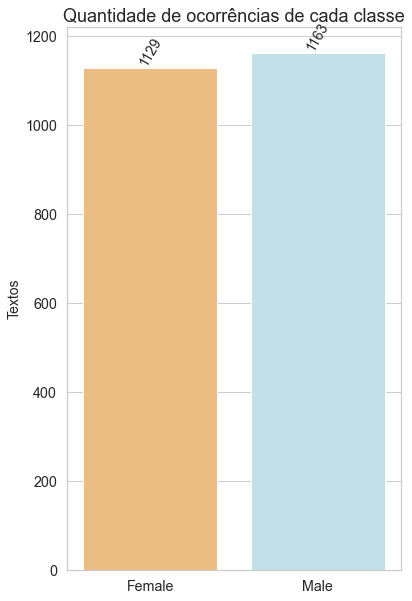

In [16]:
genres_classes = ['Female', 'Male']
genres_classes_count = [len(female_sentences), len(male_sentences)]

utils.plot_histogram_labels(x_label=genres_classes, 
                            y_label=genres_classes_count, 
                            labels=genres_classes_count, 
                            palette='RdYlBu',
                            title='Quantidade de ocorrências de cada classe', 
                            ylabel_title='Textos', 
                            width=6,
                            height=10)

## Quais as palavras mais comuns?

Para sabermos quais as palavras mais comuns presentes nos textos, primeiramente iremos obter algumas estatísticas básicas oriundas do processo de tokenização. Depois, examinaremos quais são as palavras mais comuns através de nuvens de palavras. 

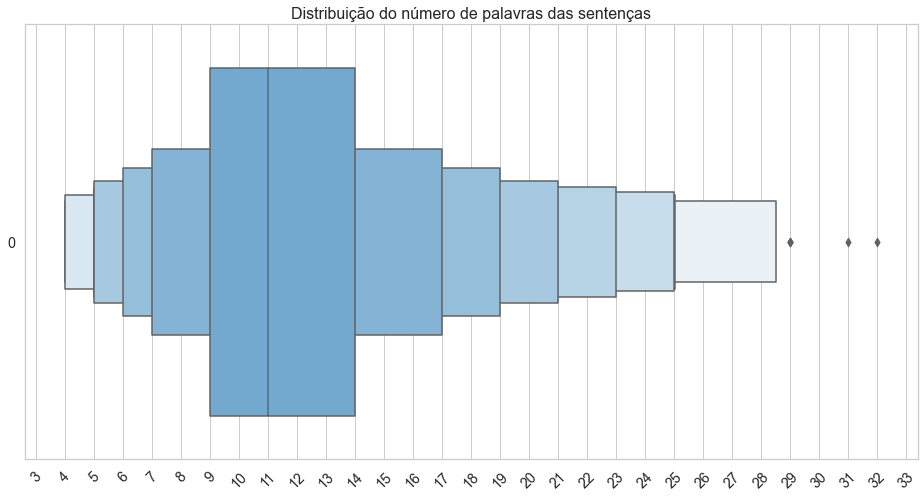

In [17]:
# Tokenização simples e remoção de pontuações, e em lowercase para pegar as stopwords com diferentes formatos
token_count = [len(utils.tokenizer(r['text'])) for r in texts]

utils.plot_distribution_large_data(token_count, 
                                   title='Distribuição do número de palavras das sentenças', 
                                   xaxis_interval=1)

Observe que o gráfico acima exibe a quantidade de palavras dos textos dos diálogos. A grande maioria está concentrada no intervalo de 8 a 17 palavras, ou seja, o MD*Gender* *dataset* possui muitos textos curtos, com apenas uma ou duas frases.

E, como era de se esperar de um dado textual, as nuvens de palavras abaixo nos mostra o que já explicamos no 1º *notebook* de análise exploratória do *Wikipedia Toxic Comments dataset*.

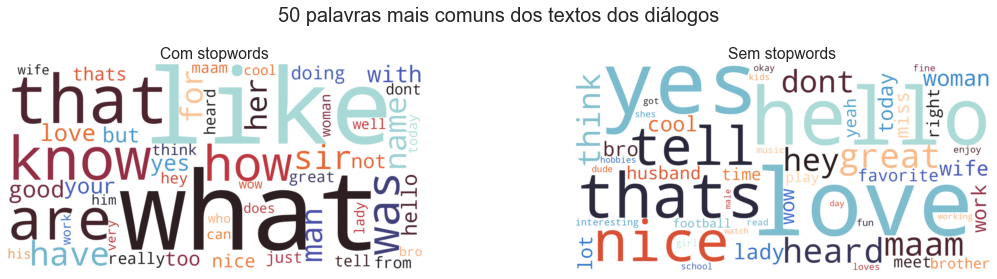

In [18]:
words_clean_count = utils.count_tokens(texts['text'])
words_count = utils.count_tokens(texts['text'], remove_stopwords=False)

general_word_counts = {
   'Com stopwords': words_count,
   'Sem stopwords': words_clean_count
}
utils.plot_word_clouds(general_word_counts, 
                       title='50 palavras mais comuns dos textos dos diálogos', 
                       figsize=(16, 4))

## Quais são as palavras mais comuns por gênero?

A partir do gráfico de distribuição abaixo, é possível notar que a grande maioria das palavras ocorrem com frequência menor ou igual a 50.

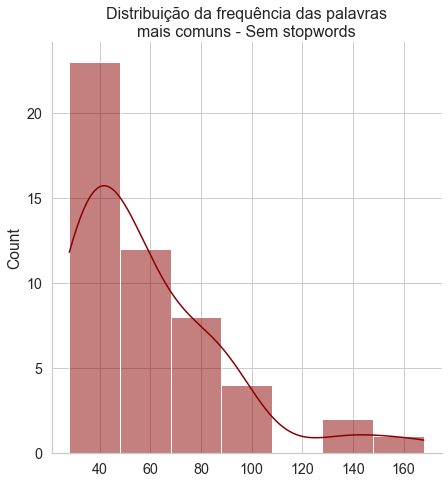

In [19]:
most_common_tokens = Counter(words_clean_count)

sns.set(style='whitegrid', font_scale=1.3)
sns.displot(data=[tup[1] for tup in most_common_tokens.items()], kde=True, color='darkred', height=6.5)
plt.title('Distribuição da frequência das palavras\nmais comuns - Sem stopwords', fontsize=16)
plt.show()

Com isso, para uma melhor análise das palavras mais relevantes de cada gênero, optamos por ignorar as palavras que ocorrem mais do que 50 vezes. Essa escolha é denotada pela linha vermelha traçada no gráfico abaixo: 

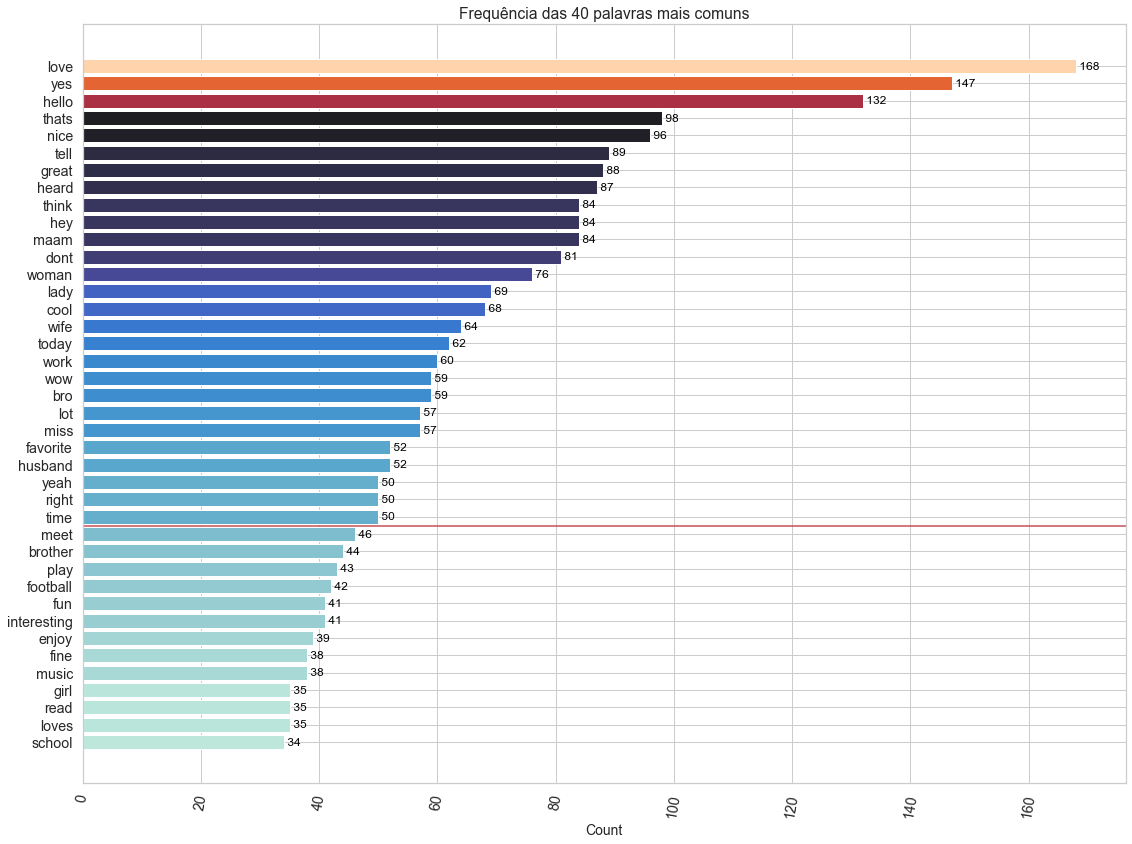

In [20]:
plt.figure(figsize=(16, 12))
utils.plot_most_frequent_elements(most_common_tokens,
                                  n_most_common=40,
                                  title='Frequência das 40 palavras mais comuns')
plt.axhline(y=12.46, color='r', linestyle='-');

In [21]:
words2ignore = [tup[0] for tup in most_common_tokens.items() if tup[1] > 50]

female_words_count = utils.count_tokens(female_sentences['text'], n_most_common=50, to_ignore=words2ignore)
male_words_count = utils.count_tokens(male_sentences['text'], n_most_common=50, to_ignore=words2ignore)

print('Quantidade de palavras que devem ser ignoradas = {}'.format(len(words2ignore)))

Quantidade de palavras que devem ser ignoradas = 24


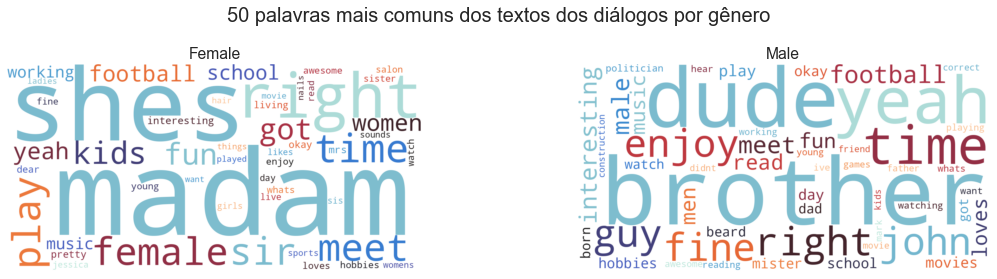

In [22]:
word_counts = {
   'Female': female_words_count,
   'Male': male_words_count
}

utils.plot_word_clouds(word_counts, 
                       title='50 palavras mais comuns dos textos dos diálogos por gênero',
                       figsize=(16, 4))

Algumas das palavras mais comuns para cada gênero tratam-se de vocativos. Advertimos que o termo "viés" é frequentemente usado para se referir a disparidades em sistemas algorítmicos que são questionáveis por razões sociais. Aqui, restringimos o uso de preconceito à sua definição tradicional.

Gostaríamos de deixar claro que reconhecemos plenamente a existência e a importância de todas as identidades de gênero. Temos como objetivo final alcançar um acessível, inclusivo e justo sistema de NLP. No entanto, esses tópicos requerem uma investigação mais sutil do que seria viável, além do que, infelizmente, o cenário de viés de gênero para assistentes virtuais é preconceituoso e bastante binário (gêneros femininos ou masculinos).

## Qual a quantidade de palavras ofensivas nos textos dos diálogos por gênero?

Aqui, tal como também foi feito no 1º *notebook* de EDA [[2](https://github.com/barbaraneves/gender-bias-in-virtual-assistants/blob/main/exploratory-data-analysis/1%20-%20Wikipedia%20Toxic%20Comments%20Dataset%20Analysis.ipynb)], verificamos a presença de palavras ofensivas e de baixo calão com base no *List of Dirty, Naughty, Obscene, and Otherwise Bad Words* [[3](https://github.com/LDNOOBW/List-of-Dirty-Naughty-Obscene-and-Otherwise-Bad-Words)]. No entanto, verificando as nuvens de palavras por gênero, podemos dizer antecipadamente que estes termos não são tão frequentes. 

In [23]:
def add_count(r):
  r['bad_words'] = utils.count_bad_words(r['text'])
  return r

male_bad_sentences = male_sentences.map(add_count).filter(lambda r: r['bad_words'] > 0)
female_bad_sentences = female_sentences.map(add_count).filter(lambda r: r['bad_words'] > 0)

  0%|          | 0/1163 [00:00<?, ?ex/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1129 [00:00<?, ?ex/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

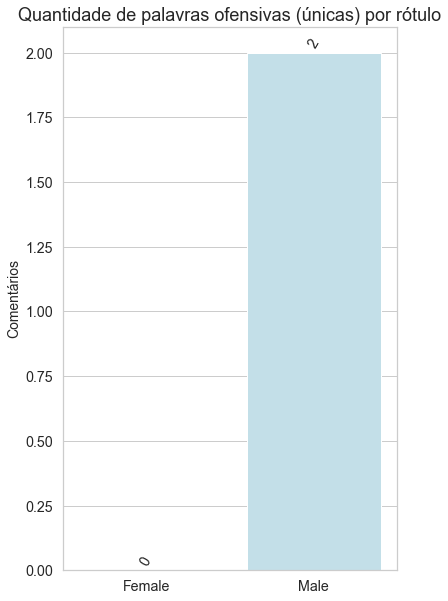

In [24]:
bad_words_per_class = [
  sum(female_bad_sentences['bad_words']),
  sum(male_bad_sentences['bad_words'])
]

utils.plot_histogram_labels(x_label=genres_classes, 
                            y_label=bad_words_per_class, 
                            labels=bad_words_per_class, 
                            palette='RdYlBu',
                            title='Quantidade de palavras ofensivas (únicas) por rótulo', 
                            ylabel_title='Comentários', 
                            width=6,
                            height=10)

Temos apenas duas palavras ofensivas presentes nos dados! Guardaremos esta informação para o futuro. Na realidade, elas nem são ofensivas, pois não denotam caráter ofensivo quando contextualizadas. Seguem os únicos dois exemplos:

In [25]:
male_bad_sentences['text'][:10]

["Lol. Jim's a hardcore biker.",
 'that man is sexy, will like both of you to hang out, he is my friend, oh wow! what else do you know']

# Referências

[[1](https://arxiv.org/pdf/2005.00614.pdf)] Dinan, E., Fan, A., Wu, L., Weston, J., Kiela, D. and Williams, A., 2020. Multi-dimensional Gender Bias Classification. *arXiv preprint arXiv:2005.00614*.

[[2](https://github.com/barbaraneves/gender-bias-in-virtual-assistants/blob/main/exploratory-data-analysis/1%20-%20Wikipedia%20Toxic%20Comments%20Dataset%20Analysis.ipynb)] 1 - Wikipedia Toxic Comments Dataset Analysis.

[[3](https://github.com/LDNOOBW/List-of-Dirty-Naughty-Obscene-and-Otherwise-Bad-Words)] Our List of Dirty, Naughty, Obscene, and Otherwise Bad Words. 2020. *GitHub*. LDNOOBW.